In [242]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv


TIME_WINDOW = 40
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# Backtest the results

train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following lines.
train = train.set_index(train.columns[0])
train.index.names = ['']
test = test.set_index(test.columns[0])
test.index.names = ['']


# Add additional technical indicators
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']


FEATURES = ["close", "high", "low", "volume"].extend(INDICATORS)

In [243]:
test

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
,,,,,,,,,,,,,
0,2021-01-04,133.520004,133.610001,126.760002,126.683434,143301900,AAPL,0,3.389453,56.613043,64.584127,8.436326,37.684748
0,2021-01-04,231.250000,231.250000,223.669998,201.544540,3088200,AMGN,0,-0.377978,48.078716,29.066703,1.082054,37.684748
0,2021-01-04,121.300003,121.800003,116.849998,112.164024,3472100,AXP,0,0.885391,54.746523,-8.190561,3.618340,37.684748
0,2021-01-04,210.000000,210.199997,202.490005,202.720001,21225600,BA,0,1.293101,50.209209,-132.990300,12.708438,37.684748
0,2021-01-04,183.000000,185.979996,180.250000,168.131119,4078300,CAT,0,1.918650,59.272549,142.190433,34.923782,37.684748
...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2023-12-29,525.979980,528.239990,523.919983,520.342346,2080100,UNH,4,-4.195767,49.266058,-73.945125,19.610609,2.911482
752,2023-12-29,260.570007,261.459991,259.670013,258.866302,4074600,V,4,2.695724,61.435315,108.048958,36.802092,2.911482
752,2023-12-29,37.380001,37.759998,37.320000,35.344772,16205200,VZ,4,0.237179,58.479746,5.362239,12.735613,2.911482


# Portfolio Optimization Algorithm

In [244]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df

df_test = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] < TEST_END_DATE)]


environment = PortfolioOptimizationEnv(
    df_test,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\USERS\BENCJ\DESKTOP\ECON4\THESIS\.VENV\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.73325447 0.49973674 0.79356218 0.56069532 0.53807884 0.51365253
 0.47050007 0.4535413  0.4616515  0.57103289 0.46439158 0.53378733
 0.61479425 0.58567169 0.80647558 0.50345004 0.72067673 0.72977091
 0.90836283 0.54361322 0.42626132 0.45990717 0.43075238 0.38731389
 0.36481715 0.39284214 0.37376857 0.32891118 0.30775351 0.41229692
 0.50103437 0.4956013  0.44858818 0.53172473 0.80985935 0.56817462
 0.75831475 0.84203104 0.59513019 0.52325379 0.57803172 0.91159258
 0.78680078 0.78992206 0.66276421 0.57279718 0.52717125 0.45082067
 0.47281647 0.58960399 0.57274243 0.62031431 0.94942914 0.57263856
 0.48849092 0.45299737 0.5057736  0.48134831 0.4135398  0.43837034
 0.60544525 0.38421973 0.45361498 0.41022459 0.42708666 0.45460458
 0.54589994 0.46778252 0.466

In [245]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

C:\Users\bencj\AppData\Local\Temp\ipykernel_24452\3962532677.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


<All keys matched successfully>

In [246]:
EIIE_results = {
    "20212024": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["20212024"]["value"] = environment._asset_memory["final"]
EIIE_results["20212024"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["20212024"]["value"], columns=['opt_net_worth'])
df_date = pd.DataFrame(EIIE_results["20212024"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1255542.5
Final accumulative portfolio value: 1.2555425
Maximum DrawDown: -0.21709480444308582
Sharpe ratio: 0.6090236373687757


In [247]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2021-03-02 00:00:00
2023-12-29 00:00:00


# Stock environment optimization algorithm

In [248]:
from finrl.meta.preprocessor.preprocessors import data_split

# Make sure we only test on the same data as the portfolio optimization algorithm
test = data_split(test, opt_start,opt_end)


In [249]:
print(test)

           date        open        high         low       close     volume  \
0    2021-03-03  124.809998  125.709999  121.839996  119.666847  112966300   
0    2021-03-03  223.520004  225.690002  221.309998  200.606552    2610600   
0    2021-03-03  140.000000  144.250000  140.000000  135.967041    4393700   
0    2021-03-03  226.360001  235.399994  225.039993  228.559998   30426000   
0    2021-03-03  212.139999  217.550003  212.009995  199.425262    2664000   
..          ...         ...         ...         ...         ...        ...   
712  2023-12-29  525.979980  528.239990  523.919983  520.342346    2080100   
712  2023-12-29  260.570007  261.459991  259.670013  258.866302    4074600   
712  2023-12-29   37.380001   37.759998   37.320000   35.344772   16205200   
712  2023-12-29   26.440001   26.629999   25.750000   24.868887   10853300   
712  2023-12-29   52.509998   52.693333   52.386665   52.042637   21948300   

      tic  day      macd     rsi_30      cci_30      dx_30  tur

In [250]:
from stable_baselines3 import PPO, TD3
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") 

trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") 

In [251]:
# Test out of sample performance

stock_dimension = len(test.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [252]:
buy_cost_list = sell_cost_list = [COMMISSION_FEE_PERCENT] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": INITIAL_CASH,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [253]:
e_trade_gym_ppo = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

df_account_value_ppo, df_actions_ppo = StockDRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym_ppo,
    deterministic=True)

hit end!


In [254]:
df_account_value_ppo.rename(columns={'date': 'Date', 'account_value' : "ppo_value"}, inplace=True)
df_account_value_ppo

,Date,ppo_value
0,2021-03-03,1.000000e+06
1,2021-03-04,9.994085e+05
2,2021-03-05,1.001433e+06
3,2021-03-08,1.002683e+06
4,2021-03-09,1.004104e+06
...,...,...
708,2023-12-22,9.620032e+05
709,2023-12-26,9.616464e+05
710,2023-12-27,9.617420e+05
711,2023-12-28,9.618485e+05


In [255]:
e_trade_gym_td3 = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

df_account_value_td3, df_actions_td3 = StockDRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym_td3)

hit end!


In [256]:
df_account_value_td3.rename(columns={'date': 'Date', 'account_value' : "td3_value"}, inplace=True)
df_account_value_td3

,Date,td3_value
0,2021-03-03,1.000000e+06
1,2021-03-04,9.975313e+05
2,2021-03-05,1.005263e+06
3,2021-03-08,1.009639e+06
4,2021-03-09,1.011700e+06
...,...,...
708,2023-12-22,1.048509e+06
709,2023-12-26,1.047461e+06
710,2023-12-27,1.047695e+06
711,2023-12-28,1.047535e+06


In [257]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (713, 8)
Annual return          0.066963
Cumulative returns     0.201283
Annual volatility      0.150850
Sharpe ratio           0.505723
Calmar ratio           0.305201
Stability              0.003747
Max drawdown          -0.219408
Omega ratio            1.089357
Sortino ratio          0.720819
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.009951
Daily value at risk   -0.018703
dtype: float64
df_dji:            date           dji
0   2021-03-02  1.000000e+06
1   2021-03-03  9.961318e+05
2   2021-03-04  9.851113e+05
3   2021-03-05  1.003338e+06
4   2021-03-08  1.013090e+06
..         ...           ...
709 2023-12-22  1.190958e+06
710 2023-12-26  1.196034e+06
711 2023-12-27  1.199576e+06
712 2023-12-28  1.201283e+06
713 2023-12-29           NaN

[714 rows x 2 columns]
df_dji:                       dji
date                    
2021-03-02  1.000000e+06
2021-03-03  9.961318e+05
2021-03-04  9.851113e+05
2021-03-05  1.003338e+06

# Compare all results

In [258]:
# Join the online algorithms

bcrp = pd.read_csv('BCRP_net_worth.csv')
crp = pd.read_csv('CRP_net_worth.csv')
olmar = pd.read_csv('OLMAR_net_worth.csv')



merged_df = pd.merge(bcrp, crp, on='Date')
merged_df = pd.merge(merged_df, olmar, on='Date')


merged_df['Date'] = pd.to_datetime(merged_df['Date'])
df_opt['Date'] = pd.to_datetime(df_opt['Date'])


# Merge the opt algorithm
merged_df = pd.merge(merged_df, df_opt, on='Date')

df_account_value_ppo['Date'] = pd.to_datetime(df_account_value_ppo['Date'])

# Merge the PPO StockEnv data
merged_df = pd.merge(merged_df, df_account_value_ppo, on='Date')


df_account_value_td3['Date'] = pd.to_datetime(df_account_value_td3['Date'])

# Merge the TD3 StockEnv data
merged_df = pd.merge(merged_df, df_account_value_td3, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2021-03-02  1.000000e+06
2021-03-03  9.961318e+05
2021-03-04  9.851113e+05
2021-03-05  1.003338e+06
2021-03-08  1.013090e+06
...                  ...
2023-12-22  1.190958e+06
2023-12-26  1.196034e+06
2023-12-27  1.199576e+06
2023-12-28  1.201283e+06
2023-12-29           NaN

[714 rows x 1 columns]
          Date  BCRP_net_worth  CRP_net_worth  OLMAR_net_worth  opt_net_worth  \
0   2021-03-03    9.947251e+05   9.957030e+05     9.958637e+05   9.967021e+05   
1   2021-03-04    9.846573e+05   9.846334e+05     9.847946e+05   9.855840e+05   
2   2021-03-05    1.006264e+06   1.003910e+06     1.004114e+06   1.004934e+06   
3   2021-03-08    1.014408e+06   1.013725e+06     1.014030e+06   1.014788e+06   
4   2021-03-09    1.018603e+06   1.015391e+06     1.015263e+06   1.016463e+06   
..         ...             ...            ...              ...            ...   
708 2023-12-22    1.397508e+06   1.242438e+06     1.166540e+06   1.244517e+06   
709

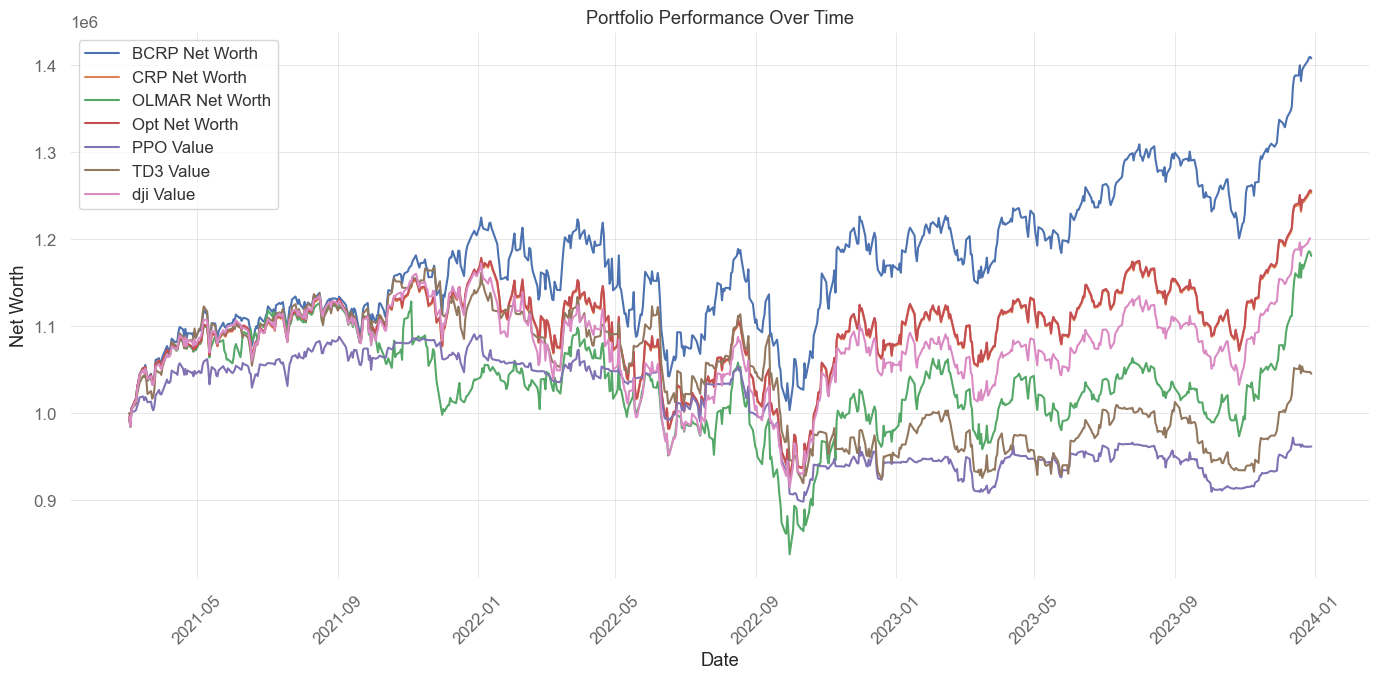

In [259]:
import matplotlib.pyplot as plt

# Plot the DataFrame
plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['BCRP_net_worth'], label='BCRP Net Worth')
plt.plot(merged_df['Date'], merged_df['CRP_net_worth'], label='CRP Net Worth')# CRP and Opt net worth are basically on the same line
plt.plot(merged_df['Date'], merged_df['OLMAR_net_worth'], label='OLMAR Net Worth')
plt.plot(merged_df['Date'], merged_df['opt_net_worth'], label='Opt Net Worth')
plt.plot(merged_df['Date'], merged_df['ppo_value'], label='PPO Value')
plt.plot(merged_df['Date'], merged_df['td3_value'], label='TD3 Value')
plt.plot(merged_df['Date'], merged_df['dji'], label='dji Value')
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [260]:
import numpy as np

# Calculate the returns each day

merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()
merged_df['opt_daily_return'] = merged_df['opt_net_worth'].pct_change()
merged_df['ppo_daily_return'] = merged_df['ppo_value'].pct_change()
merged_df['td3_daily_return'] = merged_df['td3_value'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['ppo_daily_return'], risk_free_rate),
    'TD3': calculate_sharpe_ratio(merged_df['td3_daily_return'], risk_free_rate)
}

print(sharpe_ratios)

{'BCRP': 0.7352549279955228, 'CRP': 0.4843454229225026, 'OLMAR': 0.3277444135901431, 'Opt': 0.48494909668763403, 'PPO': -0.3176011098178319, 'TD3': 0.040931557718930575}


In [261]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'OLMAR': max_drawdown(merged_df['OLMAR_net_worth']),
    'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_value']),
    'TD3': max_drawdown(merged_df['td3_value'])
}

print(max_drawdowns)


{'BCRP': -0.18076308652736583, 'CRP': -0.21648738634530096, 'OLMAR': -0.2574833118808848, 'Opt': -0.21709480444308582, 'PPO': -0.17622580475656313, 'TD3': -0.21221515898682142}


In [281]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['CRP_daily_return', 'td3_value', 'opt_net_worth', 'ppo_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
print(anova_result)

# The results do seem to be statisitcally significant


                 sum_sq      df              F  PR(>F)
Portfolio  8.156944e+14     3.0  147178.659907     0.0
Residual   5.257706e+12  2846.0            NaN     NaN
